# Goal of the project
The goal of this project is to learn a policy for an inverted pendulum model to make it do a swing-up motion. Beyond the task of inverting a pendulum, the goal is to also gain an understanding on how Q-learning works, its limitations and advantages.

To make the problem interesting, the inverted pendulum has a limit on the maximum torque it can apply, therefore it is necessary for the pendulum to do a few "back and forth" motions to be able to reach the inverted position ($\theta=\pi$) from the standing still non-inverted position ($\theta=0$). 

<img src='pendulum.png' width="120">

In the following, we will write $x = \begin{pmatrix} \theta \\ \omega \end{pmatrix}$ as the vector of states of the system. We will also work with time-discretized dynamics, and refer to $x_n$ as the state at time $t = n \Delta t$ (assuming discretization time $\Delta t$)

We want to minimize the following discounted cost function
$$\sum_{i=0}^{\infty} \alpha^i g(x_i, u_i)$$ where 
$$g(x_i, u_i) = (\theta-\pi)^2 + 0.01 \cdot \dot{\theta}_i^2 + 0.0001 \cdot u_i^2 \qquad \textrm{and} \qquad\alpha=0.99$$
This cost mostly penalizes deviations from the inverted position but also encourages small velocities and control.

## Q-learning with a table
In the first part, we will implement the Q-learning algorithm with a table. To that end, we are given a robot (defined in the package ```pendulum.py```) with a function ```get_next_state(x,u)``` that returns $x_{n+1}$ given $(x_n, u_n)$. We will assume that $u$ can take only three possible values. Note that $\theta$ can take any value in $[0,2\pi)$ and that $\omega$ can take any value between $[-6,6]$. 

In order to build the table, we will need to discretize the states. So for the learning algorithm we will use 50 discretized states for $\theta$ and 50 for $\omega$. Keep in mind that the real states of the pendulum used to generate an episode will not be discretized.


1. Write a function ```get_cost(x,u)``` that returns the current cost $g(x,u)$ as a function of the current state and control.

2. What is the dimension of the Q-table that you will need to implement (as a numpy array)? Why?

3. How can you compute the optimal policy from the Q-table? And the optimal value function? Write a function ```get_policy_and_value_function(q_table)``` that computes both given a Q-table as an input.

4. Write a function ```q_learning(q_table)``` that implements the tabular Q-learning algorithm (use episodes of 100 timesteps and an epsilon greedy policy with $\epsilon=0.1$). The function should get as an input an initial Q-table  and return a learned Q-table of similar size. Use the function ```get_next_state``` from the pendulum package to generate the episode (do not discretize the real state of the pendulum!). During learning store the cost per episode to track learning progress.

5. How many epsilodes (approximately) does it take for Q-learning to learn how to invert the pendulum when $u \in \{-4,0,4\}$? (use a learning rate of 0.1). Show the learning progress in a plot.

6. Using the simulate / animate functions (cf. below) how many back and forth of the pendulum are necessary to go from $x = [0,0]$ to the fully inverted position? Plot the time evolution of $\theta$ and $\omega$. 

7. Plot the found policy and value function as 2D images (cf. below).

8. Answer questions 5 to 7 when using $u \in \{-5,0,5\}$. What quantitative differences do you see between the computed policies in 5. and 8.? Can you explain?

9. How is learning affected when changing $\epsilon$ and the learning rate? Why?

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

import pendulum

In [2]:
# we can get the integration step used in the simulation
print(f'dt is {pendulum.DELTA_T}')

# we can get the size of its state and control vector
print(f'number of states {pendulum.NUMBER_STATES} and number of controls {pendulum.NUMBER_CONTROLS}')
print('the states are indexed as follows: theta, omega')

# we can get the maximum velocity of the pendulum (omega)
print(f'the max velocity is {pendulum.MAX_VELOCITY} rad/seconds')

dt is 0.1
number of states 2 and number of controls 1
the states are indexed as follows: theta, omega
the max velocity is 6.0 rad/seconds


In [56]:
# the next_state function allows to compute the next state given a current state and action
# This is going to be very helpful to run an episode!

# assume we set x = [theta, omega] = [0,0] and u = 5, we can get the next state using
x = np.array([0.,0.])
u = -4
x_next = pendulum.get_next_state(x, u)

print(f'the next state is {x_next}')

the next state is [ 6.2653629  -0.39175291]


[[[93 37 20]
  [28 20 52]]

 [[99 25 84]
  [22 35 48]]]
[[20 20]
 [25 22]]
[[2 1]
 [1 0]]
(2, 2)
[28 20 52]
1
[ 9 14]
0.44693020050870524


<IPython.core.display.Javascript object>


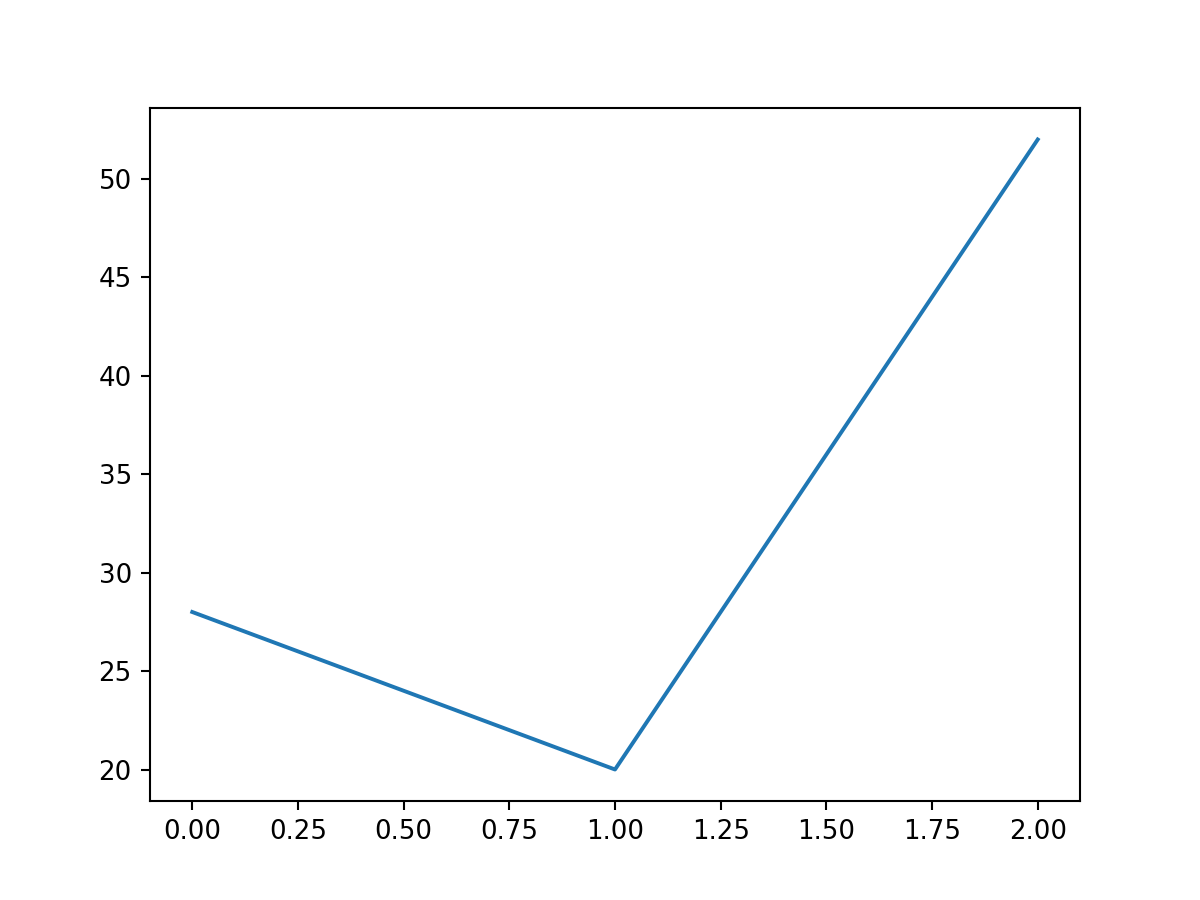

In [81]:
test_arr = np.random.randint(100, size=(12)).reshape((2,2,3))
print(test_arr)
print(np.min(test_arr, axis=2))
print(np.argmin(test_arr, axis=2))
print(np.argmin(test_arr, axis=2).shape)
print(test_arr[0][1])
print(np.argmin(test_arr[0][1]))
print(np.random.randint(50, size=[2]))
print(np.random.rand())
# plt.figure()
# plt.plot(test_arr[0][1])

In [75]:
def get_cost(x, u):
    theta = x[0]
    omega = x[1]
    
    current_state_cost = (theta - np.pi) ** 2 + 0.01 * (omega ** 2) + 0.0001 * (u ** 2)
    return current_state_cost


def get_policy_and_value_function(q_table):  # dim of q_table: 50 * 50 * 3
    # Find the corresponding optimal value function and policy according to a q_table
#     num_of_theta = q_table.shape[0]
#     num_of_omega = q_table.shape[1]
#     num_of_control = q_table.shape[2]
    
#     J_optimal_value = np.zeros([num_of_theta, num_of_omega])
#     Mu_optimal_policy = np.zeros([num_of_theta, num_of_omega])
    
    J_optimal_value = np.min(q_table, axis=2)
    Mu_optimal_policy = np.argmin(q_table, axis=2)
    return J_optimal_value, Mu_optimal_policy


alpha = 0.99
learning_rate = 0.1
u_control_policy = np.array([-4,0,4])

# we don't want 2pi to be in the set because it's the same as 0
# we generate 50 equally spaced points for theta
discretized_theta = np.linspace(0, 2*np.pi, 50, endpoint=False)

# we generate 50 equally spaced points for omega
discretized_omega = np.linspace(-6, 6, 50)


def get_closet_state_and_index(x):
    theta = x[0]
    omega = x[1]
    
    index_in_discretized_theta = np.argmin(np.abs(discretized_theta - theta))
    index_in_discretized_omega = np.argmin(np.abs(discretized_omega - omega))
#     closest_theta_state = discretized_theta[index_in_discretized_theta]
#     closest_omega_state = discretized_omega[index_in_discretized_omega]
    
    return index_in_discretized_theta, index_in_discretized_omega#, closest_theta_state, closest_omega_state
    
    
def q_learning(q_table):
    epochs = 10000  # number of epochs
    epsilon = 0.1  # probability to explore random action
    
#     updated_q_table = np.zeros_like(q_table)
    for _ in range(epochs):
        number_of_timesteps = 100  #  number of time step each episode
        
        initial_theta = np.random.rand() * 2 * np.pi
        initial_omega = np.random.rand() * 12 - 6
        current_state = np.array([initial_theta, initial_omega]) #  initial state
        
        total_TD_error = 0
        TD_error_list = []
        for i in range(number_of_timesteps):
            policy_explore_prob = np.random.rand()
            control_forces_index = 0
            
            closet_index_0, closet_index_1 = get_closet_state_and_index(current_state)  # corresponding entry in q_table of current state
            J, Mu = get_policy_and_value_function(q_table)  # optimal value function and policy of current Q table 
            if policy_explore_prob < epsilon:  # explore probability
                control_forces_index = np.random.randint(3)  # random policy
            else:
                control_forces_index = Mu[closet_index_0][closet_index_1]  # Optimal policy - argmin Q(x,u)
                    
            current_cost = get_cost(current_state, u_control_policy[control_forces_index])  # g(x,u)
            old_q_table_term = q_table[closet_index_0][closet_index_1][control_forces_index]  # Q(x,u)
            next_state = pendulum.get_next_state(current_state, u_control_policy[control_forces_index])  # next_state, x_{t+1}
            next_closet_index_0, next_closet_index_1 = get_closet_state_and_index(next_state)
            
            TD_error = current_cost + alpha * J[next_closet_index_0][next_closet_index_1] - old_q_table_term
            total_TD_error += TD_error
            
            q_table[closet_index_0][closet_index_1][control_forces_index] = old_q_table_term + learning_rate * TD_error
            
            current_state = next_state # next_state, not the discretized value
#             if _ == 0:
#                 print("current state is: ", current_state)
            
#         q_table = updated_q_table
        TD_error_list.append(total_TD_error / number_of_timesteps)
        
    
    return q_table, TD_error_list
    

In [76]:
q_table_pendulum = np.zeros([50, 50, 3])
print("q table shape: ", q_table_pendulum.shape)

q table shape:  (50, 50, 3)


In [79]:
from datetime import datetime
start = datetime.now()

q_table_pendulum, TD_errors = q_learning(q_table_pendulum)
print("training time is: ", datetime.now() - start)
plt.figure()
plt.plot(TD_errors)
plt.legend('Average TD_error')

J_optimal_value, mu_optimal_policy = get_policy_and_value_function(q_table_pendulum)

print(q_table_pendulum[0][25])
print(J_optimal_value[0][25])
print(mu_optimal_policy[0][25])
# we can also simulate the robot but we need to provide a controller of the following form
def project_2_controller(x):
    """s
        the prototype of a controller is as follows
        x is a column vector containing the state of the robot
        
        this controller needs to return a scalar
        you may want to modify this controller to use the policy table to compute control output
    """
    index1, index2 = get_closet_state_and_index(x)
    
    return u_control_policy[mu_optimal_policy[index1][index2]]
#     return 4


training time is:  0:06:55.618254
[72.22122146 71.43507395 71.8022222 ]
71.43507394559983
1


<IPython.core.display.Javascript object>


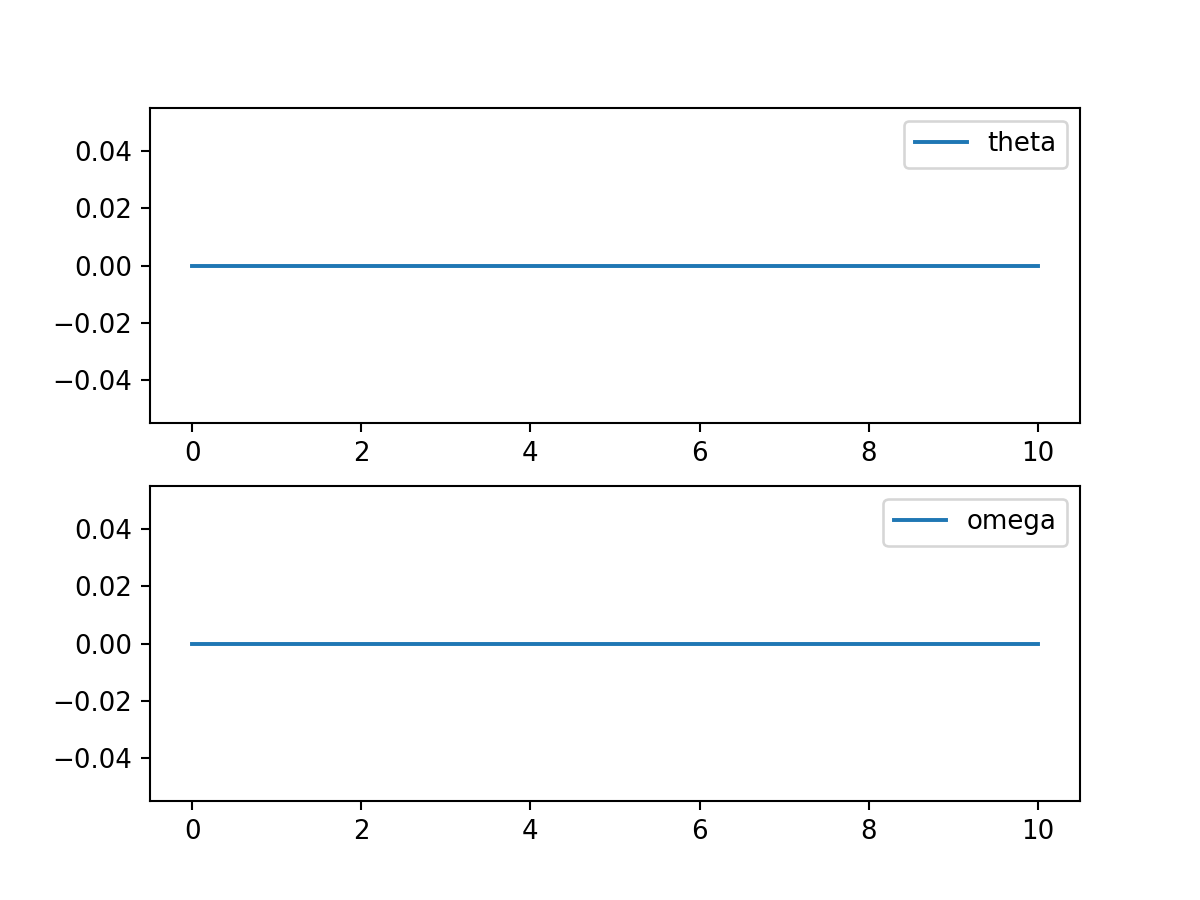

<IPython.core.display.Javascript object>


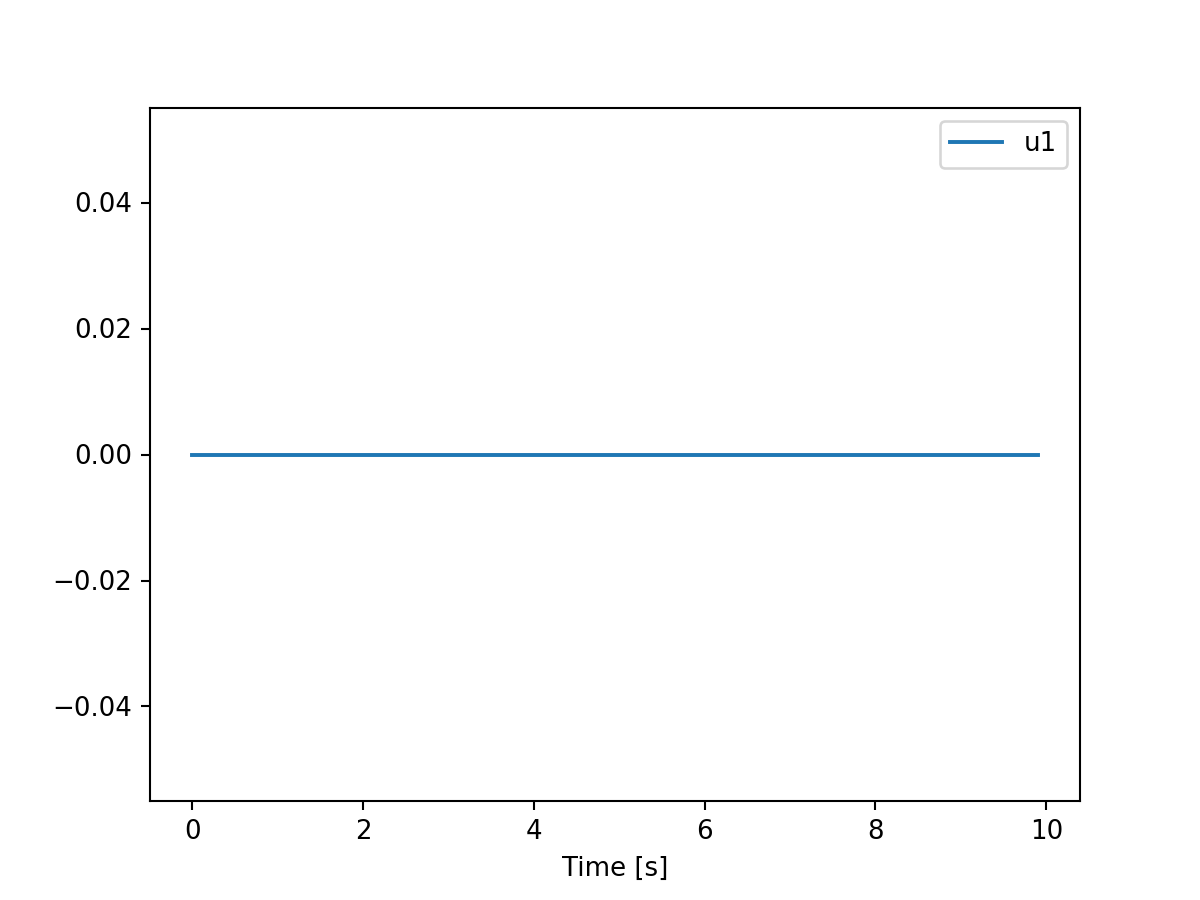

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAG7VtZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2NCByMzEwMSBiMDkzYmJlIC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMiAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTE5
IGxvb2thaGVhZF90aHJlYWRzPTMgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
DSxliIQAEf/+94gfMstp+TrXchHnrS6tH1DuRnFepL3+IAAAAwAAAwACHHgr8h1jA36boAAANaAG
nDnk/0uKTTxANBMklOx5AfoyzTNjGZoxSMjI2XqpG5muyFpkpA6oCAPVnxylzDLYhuV6SiLysV19
ZrkfNVeuuW3Q9PnAIUDhMZl7zUCMeOI9XyhO34h2N6JqaLaBMEJBECZ+5uHUUpUwEyHMK0SddgK8
GQ+8N9YKy9+mi5xcrkYkRWJQER7+UzLKhVSfJl1dCKS9cKV2QpOCIcN2cB6dc7SsaFnK+lNL704K
VLG608M5FPwh6EL0EBwAfACHU1dX1oJZzgeYkF9jIDc1B3hLlj82wiQfYvK10RzuN9Q1U62r1Osc
ElerAZGzgImHEQ9AUCDlSjLBCymJ0ZW3j+UdffVRQ4cAzpTgLL/sjPAGF6YX+yqMIy2LXBh9gX6P
dyg9TIX2+Qqsog+WDM8kjQI5D1HDegmYnuqXpe/MBsNnkgpFFgiOvUE347T2ajp0qdYwaDMgqlYf
58zP9aYJ3tJmPvGaMh2VDhGmbYiXwFVLHq36Opwl7f12x7Sxb1T9184FQlIt/RBporGW/9z2nx2y
oEwSMv63fDm8c5dmi2IKv5xjdW4tSBSTS+kLL5X5/FQkLhX9ckakEaSgYmb4KFzr+7zD2pktr220
9d3VyuJMbIx0+qpYJDVQjrgN0Wti9ZNxLnWUCvXYDf0ZvAJQZU1iwCen8eYbjTyQ78hjP2OMtxQ6
rhx4MRvCG0CM9lrLuUAAAAMAAAMAAAMAA4vC7v82dVh/Yjf5u6X9pKY2D1vSU0FyAvT9C0i2lOu5
6d10+xKTprmLCJQQx23WAdIqDMSBktDH4Q6IoXbbibqSoFfHlQS8hJvY4sYuZ+gcP0Z7klP+frIq
94jQAdPEr9QpOUL3t+oRw8ZzCpAnQDVPU0xLy1EylDTmnpUkPlf8m2WgRe/srmsI+wizvgfknC2J
VyiyezagM6t6r6yvnCZlGgNZo8k9/vYUqjLvlvYNseXk/U6o/WtRML80H01/7OIlGxztIEApdHzU
A21BEJhD97z0nqKjtaz9E21ifhLF4p3gwKA4rm0+liGZsTQkEP+wdDciC/4bfX06KaTguiNbM9DL
Qg/6nq4APWG6vXw/qhQ09ntOzR2fY7BmnMbU9vJ8wGWJ9HSYi3ccBJ+NT5hPRpr/RGbkeTiRFK1J
ASKRA2uGZ7Vjb8AAAAMAAAMAANK3cz/AeM1zm0O1T6opP6vJxy5netqwLbmzOPJp+iCSOc4y3MSj
W3gLXUBv3R5BTQt5dmFpKUJhgIlmf7MA1tTAB79p3P8xMZbGtu1iXWSNvuJOwtiKB3pPFOe8x6FE
LG2nW4Vxuulk2bLhy9HpBcJlwzTQo+ER/vLUhs+6nBb6xrnPGgQpvKbqQBTv9iSNsgYzbhO/JwW8
B3UfiuZ9iF3UCuzDYVwE3DsC1mZR7kOcB+a9eRCXUb+F2KqpVC/8TP9Amny6wGJEuKHlIhnhDPEz
Cf763neu+No6j5G3SvEXQQ7PwQY1T2gBfnDaPe9MzT8lojWRIhJsF6OW+QXU816ah95Iuzqr1f10
lSzSn61vKYssX5F61sK7wPUbFn5/3/9FvS1pt7iulOXjVBOIH4CeJWEXmLLDdaiiZOjs+3kaFekH
y3ePF9yVRFLFRCfQFPeOIMepAmXeqQH8kKVdgBzBEH5e8AJE/zoYVtuERzNfVSTKiX/Hgu0ZgGT5
Y7TV1qW3ADNM7QKcH3v4uzYo+TMEq5I0ydbUL4UIzer5Ky4qG+P/wEaGuCrqrZsOdr6Vrakx3Q6x
EXNK3thnIWqTWAcCUmJ5xDdzEzkb8nEVDiH+JsZmwjSzAFtFfExh4+RpKT/8+W5fzdKsu4AIYgrJ
WMl0YkhiMXkX2DB+xUkpciixsBvYN0OVyOUx3luHvCwQ8TLU6aj3GWMM8Zwm71u6m+zAlv7q95Vo
fTGBeXRs0LjD4Eqa8qa75y52akqNMNKt6qrgh6cwjUxcuYoWOrEWPbb/IQ2RbQRVin9ABCDfKxVm
qDV0KEtF29Vs+af+3s8NF/v+FZ5ZPJTGlejjyQepi8SYclMxxkQP23Wqs9Hk/gKD+8bV6C0CXsyJ
dyD8vd8KGpVW7ADUEXrYSbG4Mw56rXY9JlONSUSVN/6Ndu2M67dvRmhXGXupjIKtGCa313uaukgw
fOV12EShPEQYjploAQHQnkALktgMzl51mXXf/9IAfEKt/5bv6o9S+ePrqNGlwumFt2x2pZLjxAcj
APkMmZiVp6qdypjn7PZIVeqdTz75KFUMadq95UZKhvW2MY7ZbeNmJ2tdPWP99h5yDMq7NW+VD18K
RDoAzdyA+QvMgl0iU2mDRh90QbA4CUtIxrhmcivrGMxkOxyGG9ZMMNQAE957AdXz0Hnr4NKzmo1B
BNiDYEvGOYNj3M762j80wSAZ5SBX2cLRngvpUoeXUc3g9l2NO7UxFAMWkCNWlQgwnLC4hQOIw9ym
lYu//hgvxzmb8NNP1junJRKbwftmGvakbYSr2oJEc9zL6mypWUwgQfKm3/tdsoeaqXA57ZSCFVlQ
FBMHRtsEpqkAKpx0L4hKY+x/Aq2Lct/d50EF4j6aafHIJ3qIL+f4w3QNyRoP+9pRUpf8gzAWtyMQ
rnbOj/6Ts9++vXS14lj9QR1sMuG9QITe79U5odyrN1A+oXsim7dWpExi2Sxoz5A+YwEphtvkanX9
q445LFC3gSKNOsIcUnau3ZxPV3Zgh5Iufe9xhuFK8zI2pmcJ1dOx3Z6su2nz/9sMjm9u8yvqmv9r
B++CpPY/wsGptkNmXQ0dmOOD+Mt4VichmsElv97TI58AsCKTm5Tyj4BIdaUEYTG0flkBqQ3jtAG6
ss0u8nHA4Kv1Wq6m7S+TE

In [80]:
# we can now simulate for a given number of time steps - here we do 10 seconds
T = 10.
x0 = np.array([0, 0])
t, x, u = pendulum.simulate(x0, project_2_controller, T)

# we can plot the results
plt.figure()

plt.subplot(2,1,1)
plt.plot(t, x[0,:])
plt.legend(['theta'])

plt.subplot(2,1,2)
plt.plot(t, x[1,:])
plt.legend(['omega'])

# we can also plot the control
plt.figure()
plt.plot(t[:-1], u.T)
plt.legend(['u1'])
plt.xlabel('Time [s]')


# now we can also create an animation
pendulum.animate_robot(x)

We also need to discretize the state space, we discretize $\theta \in [0, 2\pi]$ in 50 states and $\dot{\theta} \in [-6, 6]$ is 50 states. For example:

In [67]:
# we don't want 2pi to be in the set because it's the same as 0
# we generate 50 equally spaced points for theta
discretized_theta = np.linspace(0, 2*np.pi, 50, endpoint=False)

# we generate 50 equally spaced points for omega
discretized_omega = np.linspace(-6, 6, 50)

# now given an arbitrary continuous state theta
theta_arbitrary = 0
omega_arbitrary = 0

# we can find the index of the closest element in the set of discretized states
index_in_discretized_theta = np.argmin(np.abs(discretized_theta - theta_arbitrary))
index_in_discretized_omega = np.argmin(np.abs(discretized_omega - omega_arbitrary))

# and find the closed discretized state
closest_theta_state = discretized_theta[index_in_discretized_theta]
closest_omega_state = discretized_omega[index_in_discretized_omega]

print(f'the discretized theta closest to {theta_arbitrary} is {closest_theta_state} with index {index_in_discretized_theta}')
print(f'the discretized omega closest to {omega_arbitrary} is {closest_omega_state} with index {index_in_discretized_omega}')

the discretized theta closest to 0 is 0.0 with index 0
the discretized omega closest to 0 is 0.12244897959183643 with index 25


<IPython.core.display.Javascript object>


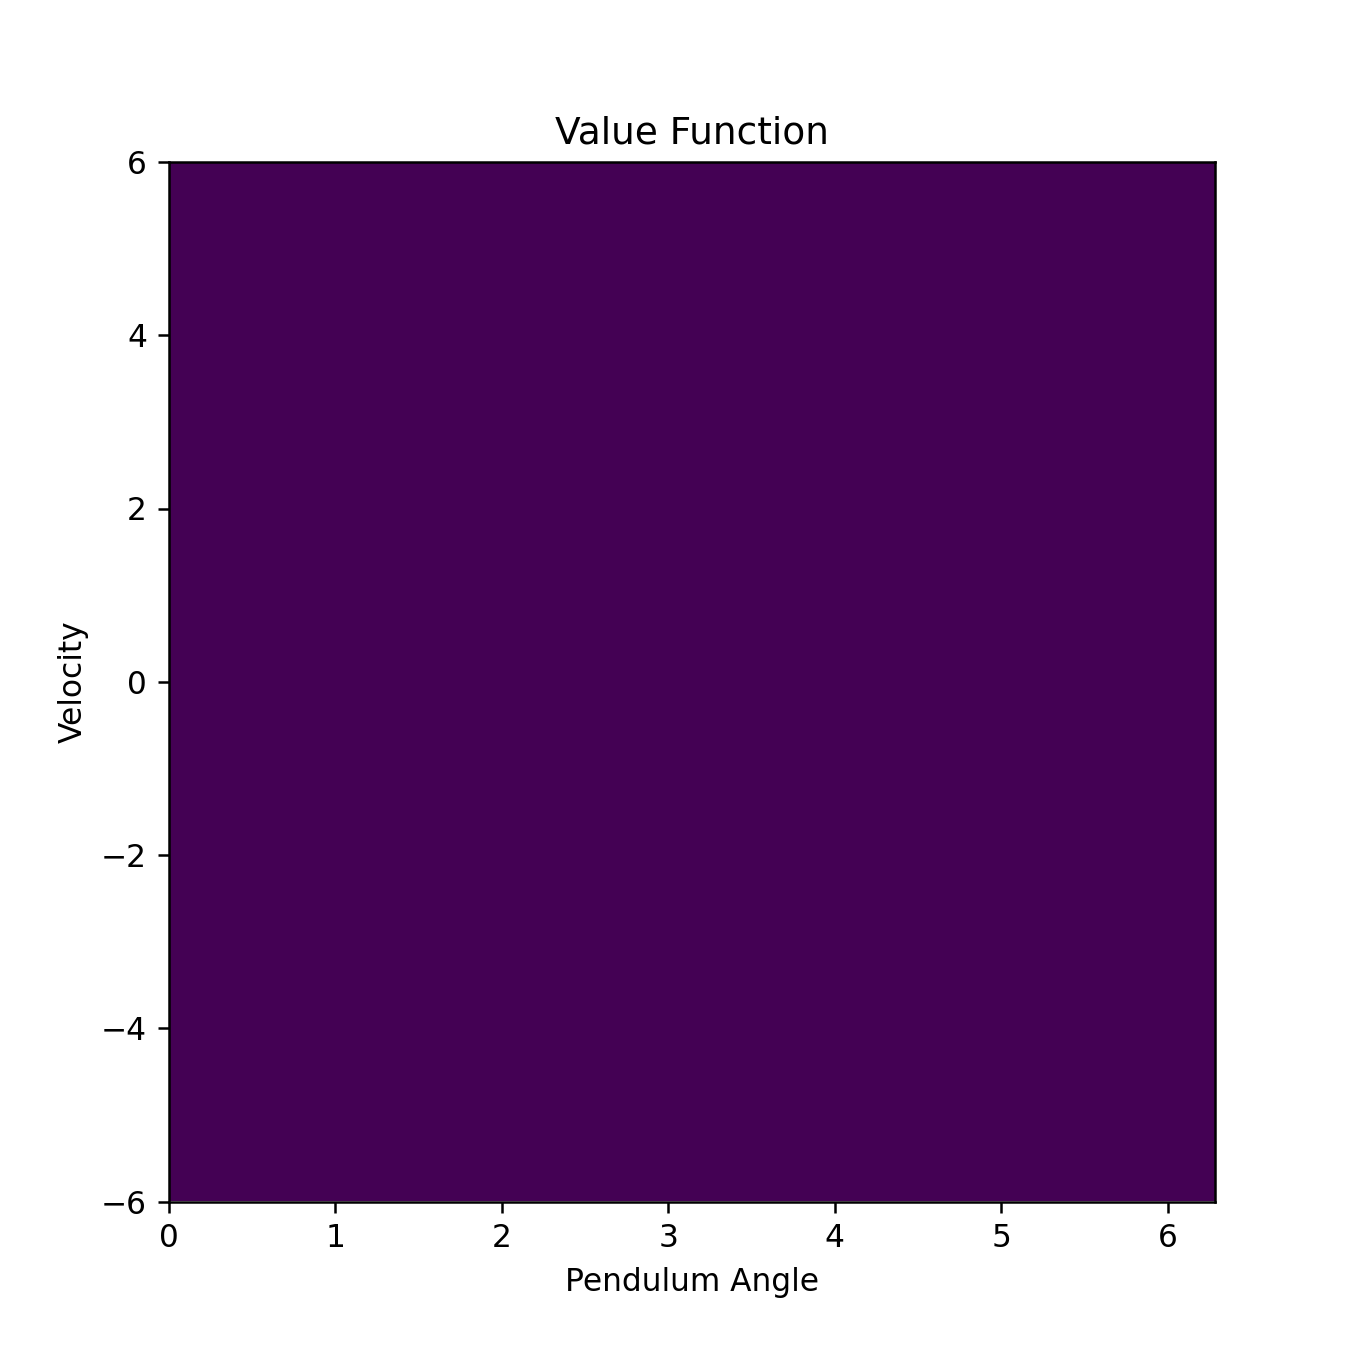

<IPython.core.display.Javascript object>


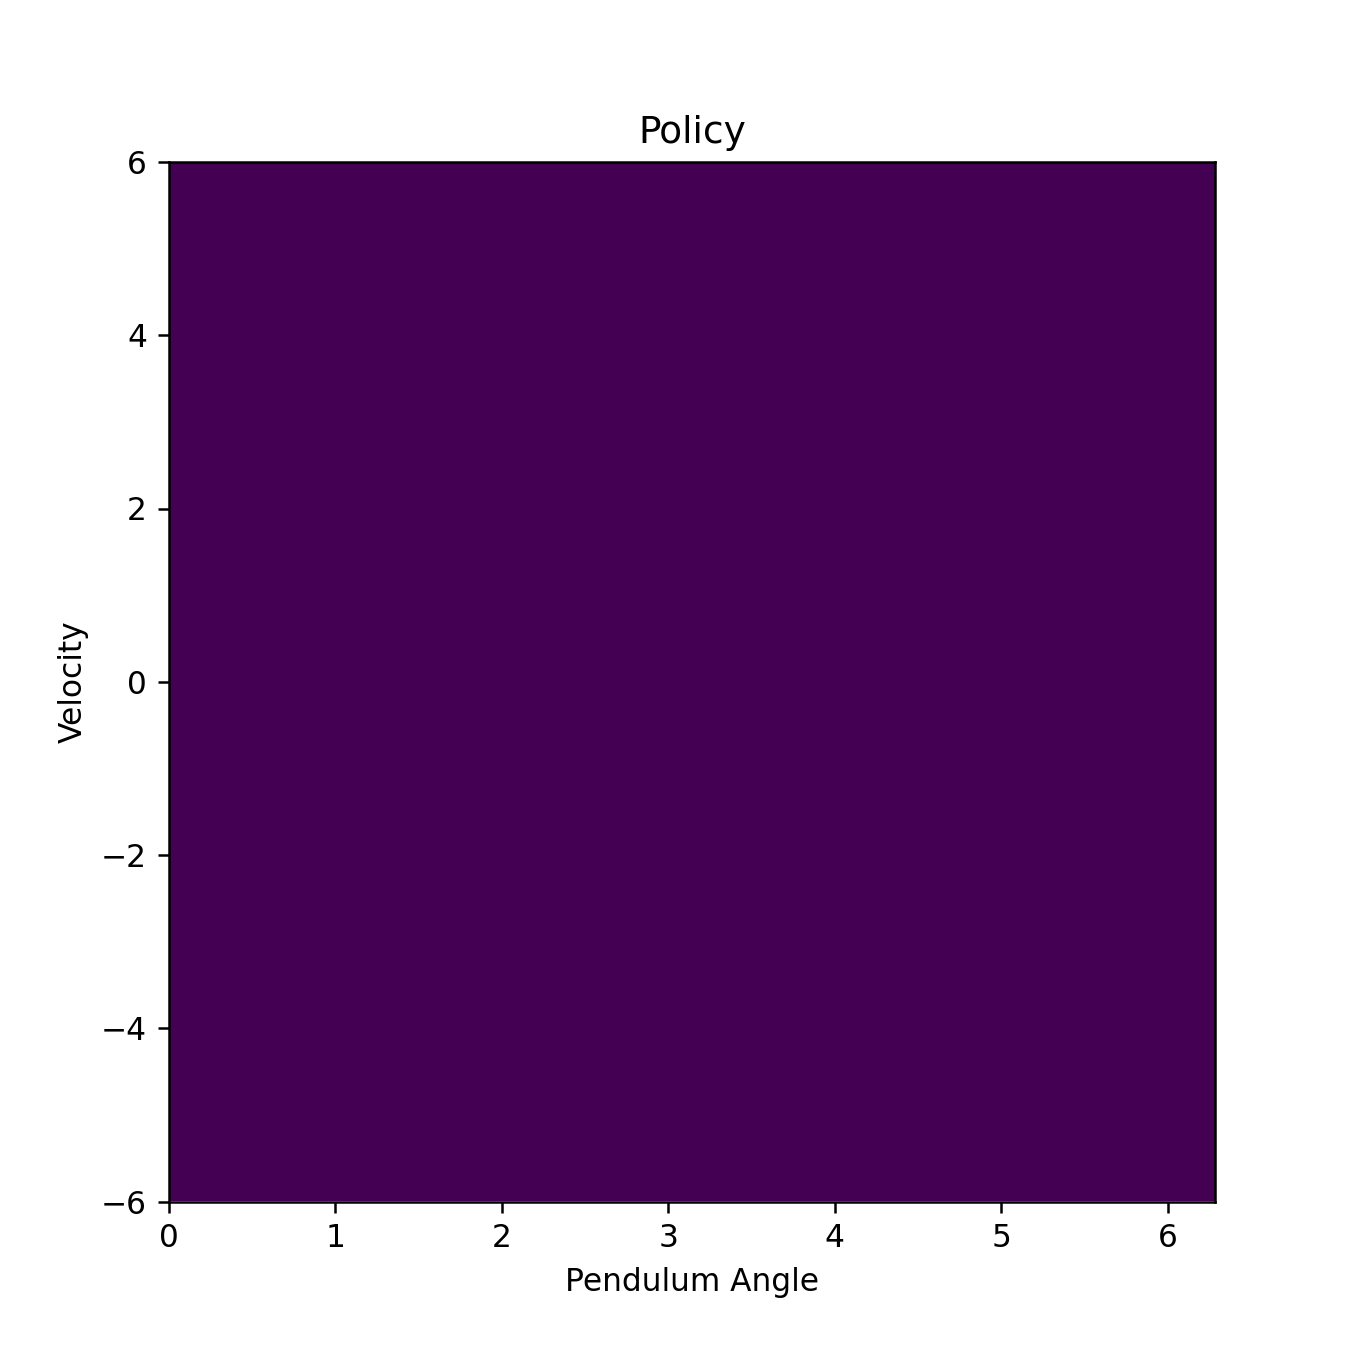

Text(0.5, 1.0, 'Policy')

In [8]:
# here is some code to plot results, assuming a policy and a value function are given
# this can be used to answer questions in both Part 1 and 2

value_function = np.zeros([50,50])
policy = np.zeros([50,50])

# we plot the value function
plt.figure(figsize=[6,6])
plt.imshow(value_function, extent=[0., 2*np.pi, -6, 6], aspect='auto')
plt.xlabel('Pendulum Angle')
plt.ylabel('Velocity')
plt.title('Value Function')

# we plot the policy
plt.figure(figsize=[6,6])
plt.imshow(policy, extent=[0., 2*np.pi, -6, 6], aspect='auto')
plt.xlabel('Pendulum Angle')
plt.ylabel('Velocity')
plt.title('Policy')